#### Introduction au Machine Learning MINES ParisTech PSL (1A) Nov 2018
## Demo: Neural Style Transfer with PyTorch
simon.tamayo@mines-paristech.fr

This tutorial is one of the demos used in the course “Introduction to Machine Learning” at MINES ParisTech - PSL Research University, lectured by Simon Tamayo.
#### Acknowledgement
Most of this demo was adapted from the PyTorch tutorial on Style Transfer (https://pytorch.org/tutorials/advanced/neural_style_tutorial.html), which explains how to implement the Neural-Style algorithm developed by L. A. Gatys, A. S. Ecker and M. Bethge.

In [3]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
import copy

### Loading, displaying and saving functinos

In [4]:
# desired size of the output image
imsize = 256  # use small size if no gpu
loader = transforms.Compose([
    transforms.Scale(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor

def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image

def save_image(input, path):
    image = input.data.clone().cpu()
    image = image.view(3, imsize, imsize)
    image = unloader(image)
    plt.imsave(path, image)
    
def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

/Users/simontamayo/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


### Load input image and input style

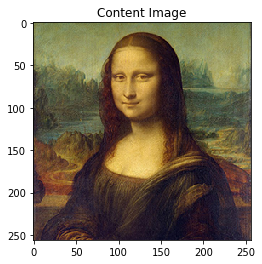

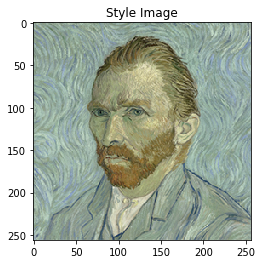

In [5]:
input_name = 'monalisa'
style_name = 'vangogh'
style_img = image_loader('./images/'+style_name+'.jpg')
content_img = image_loader('./images/'+input_name+'.jpg')

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

unloader = transforms.ToPILImage()  # reconvert into PIL image
plt.ion()
plt.figure()
imshow(content_img, title='Content Image')
plt.figure()
imshow(style_img, title='Style Image')

### Define content and style loss classes

In [6]:
class ContentLoss(nn.Module):
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input
    
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)
    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL
    G = torch.mm(features, features.t())  # compute the gram product
    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

### Load the deep neural network (Vgg19)

In [7]:
cnn = models.vgg19(pretrained=True).features.eval()

### Style loss functions

In [8]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)
    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std
    
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)
    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []
    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)
    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
        model.add_module(name, layer)
        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)
        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)
    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:(i + 1)]
    return model, style_losses, content_losses

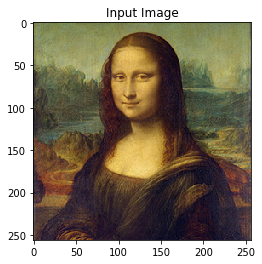

In [9]:
input_img = content_img.clone()
# if you want to use a white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size())

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

### Optimization functions

In [10]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=200,
                       style_weight=80000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)
    print('Optimizing...')
    run = [0]
    while run[0] <= num_steps:
        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0
            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss
            style_score *= style_weight
            content_score *= content_weight
            loss = style_score + content_score
            loss.backward()
            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()
                plt.figure()
                imshow(input_img, title='Iteration '+str(run[0]))
                plt.ioff()
                plt.show()
            return style_score + content_score
        optimizer.step(closure)
    # a last correction...
    input_img.data.clamp_(0, 1)
    return input_img

## Run style transfer

Finally, run the algorithm



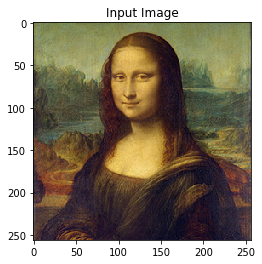

Building the style transfer model..
Optimizing...
run [50]:
Style Loss : 7.036402 Content Loss: 5.816941



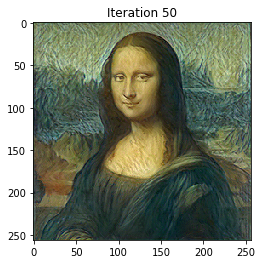

run [100]:
Style Loss : 3.017244 Content Loss: 4.300057



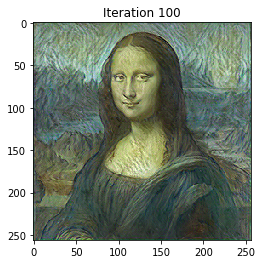

run [150]:
Style Loss : 1.483691 Content Loss: 3.693414



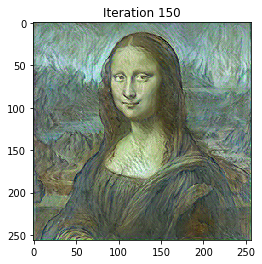

run [200]:
Style Loss : 0.783773 Content Loss: 3.334886



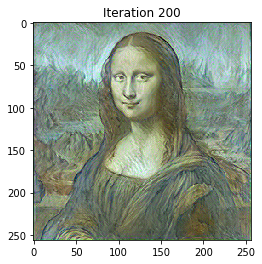

Finished


In [11]:
plt.figure()
imshow(input_img, title='Input Image')
plt.ioff()
plt.show()
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)
print('Finished')

### Save results

In [12]:
path = './results/'+input_name+'_'+style_name+'.png'
save_image(output, path)